# Time Series Prediction of Wind Speed using Deep Learning Methods
In this notebook, I builds a few different deep learning models including Convolutional and Recurrent Neural Networks (CNNs and RNNs). Unlike other machine learning algorithms, long short-term memory recurrent neural networks are capable of automatically learning features from sequence data, support multi-variate data, and can output a variable length sequences that can be used for multi-step forecasting. 
In this study, a weather data set provided by National Oceanic and Atmospheric Administration of South Plains Region of Texas is is used which consists of weather data of every hour in the year 2010. 

In [38]:
import os
import random
import time
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import tensorflow_addons as tfa

from math import ceil

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

## Load and prepare data

In [2]:

def cleandata(data):
    for col in data.columns:
        data = data[data[col] != -9999.0]
        data = data[data[col] != -9999.99]
    data = data[data['Wind Speed (m/s)'] >= 0]
    return data

def findnanrows(df):
    is_NaN = df.isnull() 
    row_has_NaN = is_NaN.any(axis=1) 
    rows_with_NaN = df[row_has_NaN] 
    return rows_with_NaN

def interpolatedata(df):
    filldf = df.groupby(pd.Grouper(freq='H')).mean()
    dfnan = findnanrows(filldf)
    print("==> %s rows have been filled <==" %len(dfnan))
    filldf = filldf.interpolate().round(2)
    return filldf

In [3]:
class VizData():
    def __init__(self, data):
        self.data = data
        
    def plotfeatures(self, mode, title):
        features = self.data.columns.tolist()
        plot_features = self.data.groupby(pd.Grouper(freq=str(mode)+'T')).mean()
        plot_features = plot_features[features]
        plot_features.index = plot_features.index
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), facecolor="w", edgecolor="k")
        for i, feature in enumerate(features):
            axes[i // ncols, i % ncols].plot(plot_features[feature])
            axes[i // ncols, i % ncols].set_title(f'{feature} - {title}')     
        plt.tight_layout()
        plt.show()

    def plothist2d(self, feature):
        f = self.data.columns.tolist()
        features = [x for x in f if x != feature]
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
        for i, feature_x in enumerate(features):
            if i == nrows * ncols - 2:
                ax = plt.subplot(nrows,1,ncols)
                counts, xedges, yedges, img = plt.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')  
                plt.colorbar(img, ax=ax)
                plt.gca()
            else:
                ax = plt.subplot(nrows,ncols,i+1)
                counts, xedges, yedges, img = ax.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')  
                plt.colorbar(img, ax=ax)
                plt.gca()
        plt.show()

    def plotbox(self, mode):
        plot_features = self.data.groupby(pd.Grouper(freq=str(60)+'T')).mean().copy()
        plot_features[mode] = [eval('x.%s'%mode) for x in plot_features.index] 
        plot_features.boxplot('Wind Speed (m/s)', by=mode, figsize=(12, 8), grid=False)
        plt.show()

In [4]:
weather = pd.read_csv("SouthPlainsWindData.csv", parse_dates=True, index_col="Date Time")
weather.index.name = 'datetime'

print("Size before cleaning data:", weather.shape)
weather = cleandata(data=weather)
print("Size after cleaning data:", weather.shape)

print("Size before filling data:", weather.shape)
#weather = filldata(weather)
weather = interpolatedata(weather)
print("Size after filling data:", weather.shape)

weather.head()

Size before cleaning data: (8760, 4)
Size after cleaning data: (8760, 4)
Size before filling data: (8760, 4)
==> 0 rows have been filled <==
Size after filling data: (8760, 4)


,Wind Speed (m/s),Pressure (atm),Air temperature (deg C),Wind direction (deg)
datetime,,,,
2010-01-01 00:00:00,9.00,0.88,13.18,176.67
2010-01-01 01:00:00,9.80,0.88,13.16,180.67
2010-01-01 02:00:00,10.59,0.89,13.14,182.33
2010-01-01 03:00:00,11.29,0.89,12.68,188.67
2010-01-01 04:00:00,10.13,0.89,11.83,201.00


In [5]:
weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind Speed (m/s),8760.0,9.012703,3.999971,0.18,6.0300,8.92,11.97,24.76
Pressure (atm),8760.0,0.883252,0.006845,0.86,0.8800,0.88,0.89,0.90
Air temperature (deg C),8760.0,14.935725,10.464303,-17.10,7.3075,15.95,22.81,35.95
Wind direction (deg),8760.0,180.010057,92.677050,0.00,121.9175,186.00,233.67,359.67


In [6]:
usecols = ["Pressure (atm)", "Air temperature (deg C)", "Wind direction (deg)", "Wind Speed (m/s)"]
weather = weather[usecols]
print("weather dataset shape:", weather.shape)

weather dataset shape: (8760, 4)


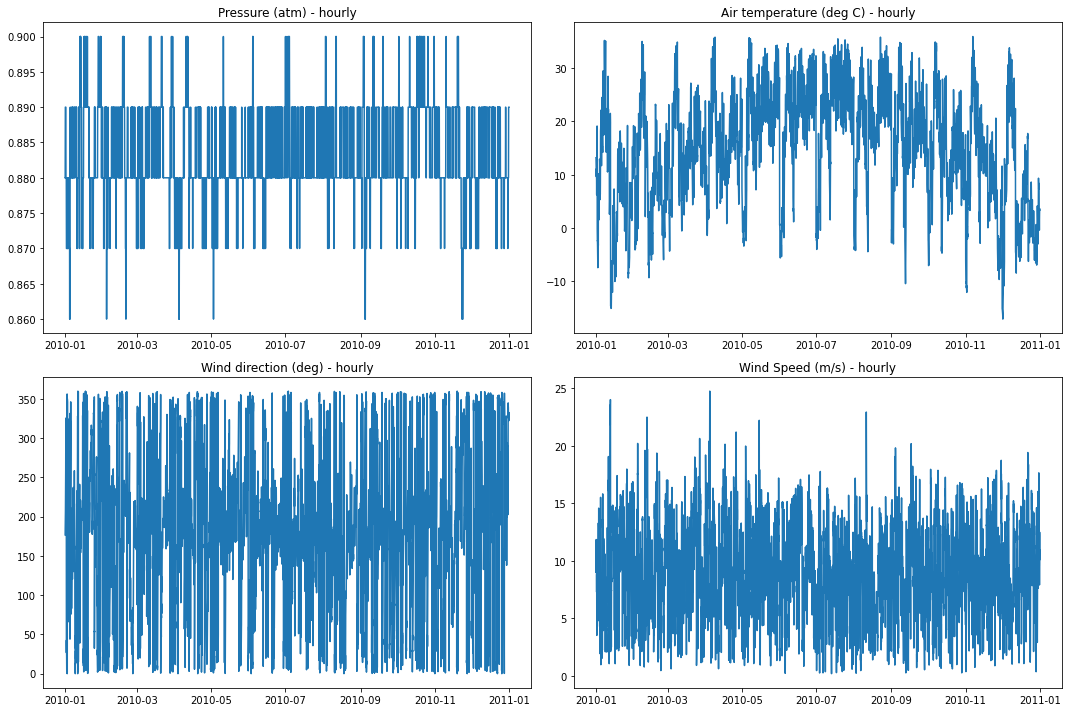

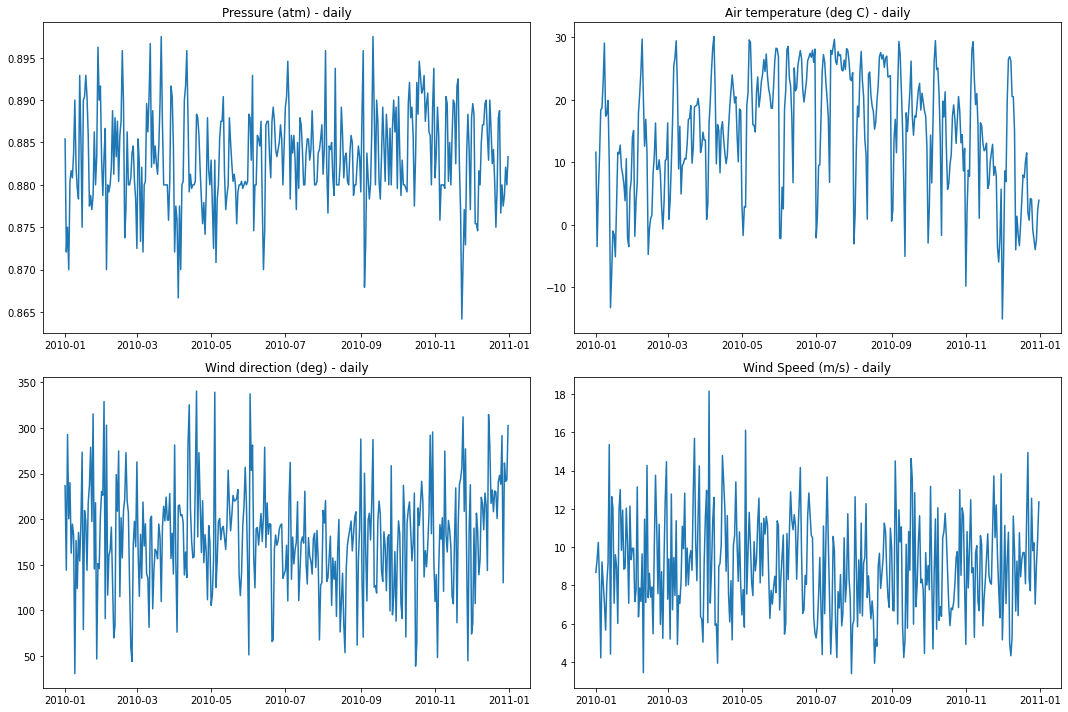

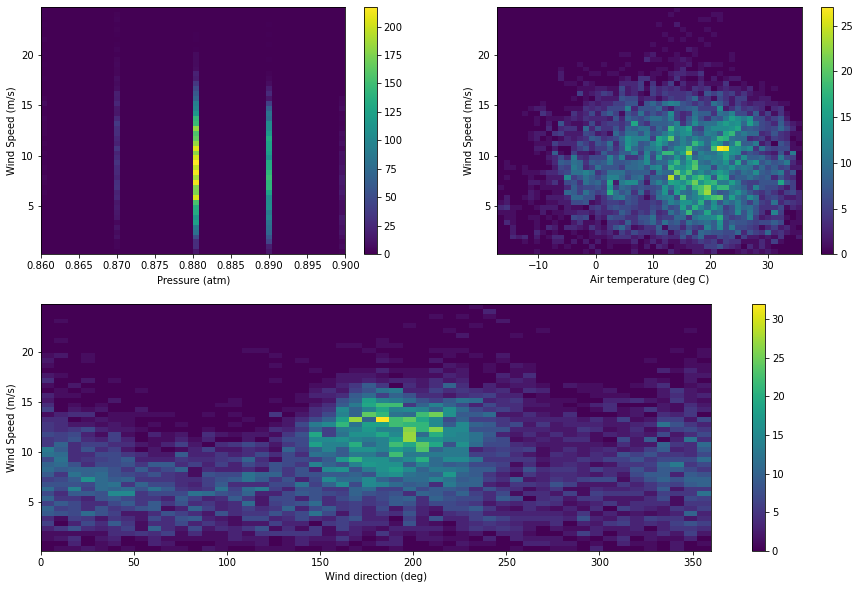

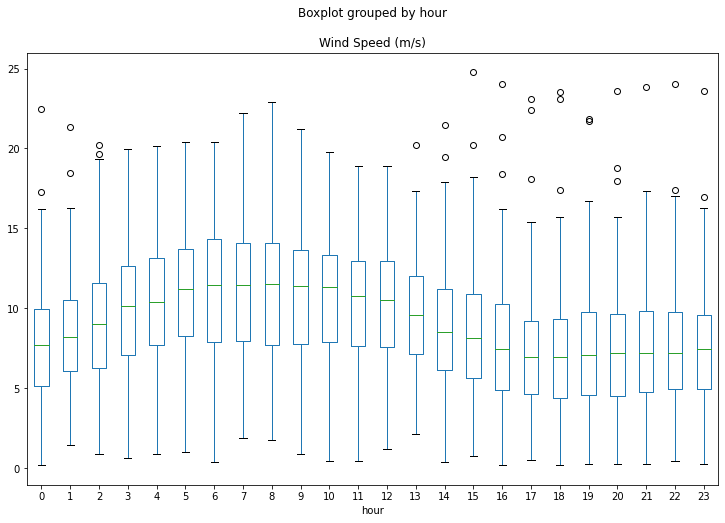

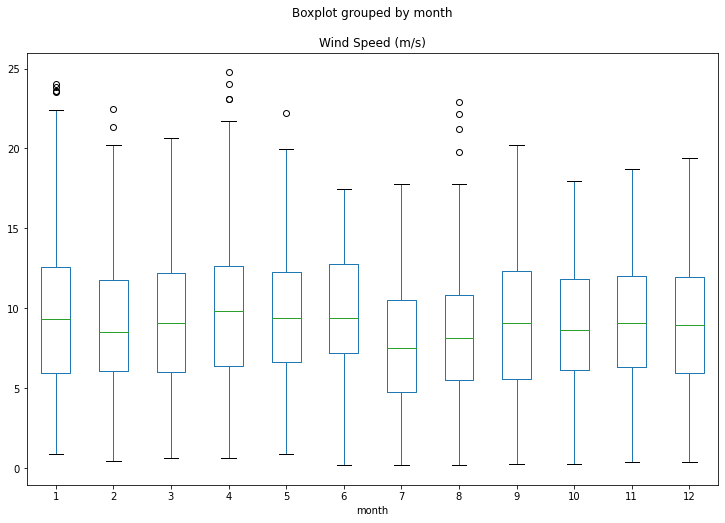

In [7]:
vd = VizData(data=weather)
vd.plotfeatures(mode=60, title="hourly")
vd.plotfeatures(mode=60*24, title="daily")
vd.plothist2d(feature="Wind Speed (m/s)")
vd.plotbox(mode="hour")
vd.plotbox(mode="month")

## Building Classes

In [8]:
class DataPreprocessing():
    def __init__(self, data, sampling_window, **kwargs):
        self.data = data
        self.sampling_window = sampling_window
        self.trainsize = kwargs.get('trainsize', 0.7)
        self.valsize = kwargs.get('valsize', 0.2)

    def datasplit(self, **kwargs):
        self.addcyclics = kwargs.get('addcyclics', False)
        self.normalize = kwargs.get('normalize', None)
        self.features = kwargs.get('features', None)
        
        self.resample_data = self.data.resample(str(self.sampling_window)+'T').mean()
        
        if self.resample_data.isna().sum().sum() > 0:
            raise Exception(f"Oops! there are some NaN values in resampled data.")

        if self.features is not None:
            self.resample_data = self.resample_data[self.features]
        if self.addcyclics:
            self.resample_data = self.__class__.cyclical(self.resample_data)   
            self.features = self.resample_data.columns
        
        self.train_df = self.resample_data[0:int(len(self.resample_data)*self.trainsize)]
        self.val_df = self.resample_data[int(len(self.resample_data)*self.trainsize):int(len(self.resample_data)*(self.trainsize+self.valsize))]
        self.test_df = self.resample_data[int(len(self.resample_data)*(self.trainsize+self.valsize)):]
                
        if self.normalize is not None:
            if self.normalize == 'MinMaxScaler':
                self.scaler = MinMaxScaler(feature_range=(0, 1))
            elif self.normalize == 'StandardScaler':
                self.scaler = StandardScaler()
            # normalizing input features
            self.train_df = pd.DataFrame(self.scaler.fit_transform(self.train_df), columns=self.train_df.columns, index=self.train_df.index)
            self.val_df = pd.DataFrame(self.scaler.transform(self.val_df), columns=self.val_df.columns, index=self.val_df.index)
            self.test_df = pd.DataFrame(self.scaler.transform(self.test_df), columns=self.test_df.columns, index=self.test_df.index)
            
        return self.train_df, self.val_df, self.test_df
    
    @staticmethod
    def cyclical(data):
        data = data.copy()
        # Extracting the hour of day
        data["hour"] = [x.hour for x in data.index]
        # Creating the cyclical daily feature 
        data["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in data["hour"]]
        data["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in data["hour"]]
        # Extracting the timestamp from the datetime object 
        data["timestamp"] = [x.timestamp() for x in data.index]
        # Seconds in day 
        s = 24 * 60 * 60
        # Seconds in year 
        year = (365.25) * s
        data["month_cos"] = [np.cos((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data["month_sin"] = [np.sin((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data = data.drop(['hour', 'timestamp'], axis=1)
        return data

In [9]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 batch_size, sequence_stride,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift + label_width

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.input_width + self.shift
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Offset: {self.shift}',
            f'Label column name(s): {self.label_columns}',
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def make_dataset(self, data, sequence_stride):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=sequence_stride, 
            shuffle=False,
            batch_size=self.batch_size,
        )
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df, self.sequence_stride)
    @property
    def val(self):
        return self.make_dataset(self.val_df, self.sequence_stride)
    @property
    def test(self):
        return self.make_dataset(self.test_df, self.sequence_stride)
    
    @property
    def flattrain(self):
        return self.make_dataset(self.train_df, self.label_width)
    @property
    def flatval(self):
        return self.make_dataset(self.val_df, self.label_width)
    @property
    def flattest(self):
        return self.make_dataset(self.test_df, self.label_width)
 
    def randomplots(self, mc=None, max_subplots=3, **kwargs):   
        plot_col = kwargs.get('plot_col', self.label_columns[0])

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest)))  

        plot_col_index = self.column_indices[plot_col]
        indexes = random.sample(range(len(real_x)), max_subplots)

        if mc is not None:
            reshape_real_x = mc.reshape(real_x)
            max_subplots = max_subplots + 1

        plt.figure(figsize=(12, 8))
        for n in range(max_subplots):
            plt.subplot(max_subplots, 1, n+1)
            if n == max_subplots - 1 and mc is not None: 
                plt.plot(real_y[:, :, label_col_index].reshape(-1, 1))
                plt.plot(predictions.reshape(-1, 1))

            else: 
                plt.plot(self.input_indices, real_x[indexes[n], :, plot_col_index], 
                         label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                    label_col_index = plot_col_index

                if label_col_index is None:
                    continue

                plt.scatter(self.label_indices, real_y[indexes[n], :, label_col_index], 
                            marker='p', edgecolors='k', label='Labels', 
                            c='#2ca02c', s=64)
                if mc is not None:
                    predictions = mc.model.predict(reshape_real_x)
                    plt.scatter(self.label_indices, predictions[indexes[n], :], 
                                marker='*', edgecolors='k', label='Predictions',
                                c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
                plt.title(f'{plot_col} [scaled]')
        plt.xlabel('Timesteps')
        
    def plotforecast(self, mc, title, **kwargs):
        withinputs = kwargs.get('withinputs', False)
        windows = kwargs.get('windows', None)
        labels = ["Actual values", "Predicted values"]

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest)))
        pred_y = mc.model.predict(mc.reshape(real_x))

        real_y = real_y.reshape(-1, 1)
        pred_y = pred_y.reshape(-1, 1)

        plt.figure(figsize=(15,5))
        if withinputs:
            plt.plot(self.test_df[self.label_columns].values[:self.input_width+len(pred_y[:windows])], label=labels[0])
            plt.plot(np.arange(self.input_width, self.input_width+len(pred_y[:windows])), pred_y[:windows], label=labels[1])
        else:
            plt.plot(real_y[:windows], label=labels[0])
            plt.plot(pred_y[:windows], label=labels[1])
        plt.title(f'{title}: {self.input_width} previous timesteps-based {self.label_width} future timesteps forecasting')
        plt.xlabel("Test dataset points")
        plt.legend(frameon=False)
        plt.show()

In [10]:
class ModelingClass():
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1):
        self.mapdataset = mapdataset
        self.epochs = epochs
        self.patience = patience
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.loss = loss 
        self.metrics = metrics
        self.label_feature_number = list(map(lambda x: x[1].numpy(), mapdataset.train.take(1)))[0].shape[2]
 
    def reshape(self, data):
        return data
    
    # build the model
    def modelbuild(self):
        # define model
        model = None
        return model
        
    def traincallback(self):
        # simple early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=self.patience, verbose=1)
        return early_stopping 
    
    # train the model
    def train(self):
        # Building the model
        self.model = self.modelbuild()
        # Initiating the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Instantiate an optimizer before passing it to model.compile() or pass it by its string identifier.
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        # fit network
        if (self.mapdataset.val is not None):
            self.history = self.model.fit(
                self.mapdataset.train,
                validation_data=self.mapdataset.val,    
                epochs=self.epochs, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        else:
            self.history = self.model.fit(
                self.mapdataset.train,    
                epochs=self.epochs, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        return self.history
    
    def computemetrics(self, mapdata): 
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdata)))
        real_y = real_y.reshape(real_y.shape[0], real_y.shape[1])
        pred_y = self.model.predict(mapdata)
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[1])

        RMSE = mean_squared_error(real_y, pred_y, squared=False)
        MSE = mean_squared_error(real_y, pred_y)
        MAE = mean_absolute_error(real_y, pred_y)
        MAPE = 100*mean_absolute_percentage_error(real_y, pred_y)
        R2 = r2_score(real_y, pred_y)   
        # calculate the metric score for each timestep
        rmse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values', squared=False)
        mse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values')
        mae_scores = mean_absolute_error(real_y, pred_y, multioutput='raw_values')
        mape_scores = 100*mean_absolute_percentage_error(real_y, pred_y, multioutput='raw_values')
        r2_scores = r2_score(real_y, pred_y, multioutput='raw_values')
        print('rmse: %.4f [%s]' %(RMSE, ', '.join(['%.4f' % s for s in rmse_scores])))
        print('mse : %.4f [%s]' %(MSE, ', '.join(['%.4f' % s for s in mse_scores])))
        print('mae : %.4f [%s]' %(MAE, ', '.join(['%.4f' % s for s in mae_scores])))
        print('mape: %.4f [%s]' %(MAPE, ', '.join(['%.4f' % s for s in mape_scores])))
        print('r2  : %.4f [%s]' %(R2, ', '.join(['%.4f' % s for s in r2_scores])))
    
    @property
    def trainmetrics(self):
        return self.computemetrics(self.mapdataset.train)
    @property
    def valmetrics(self):
        return self.computemetrics(self.mapdataset.val)
    @property
    def testmetrics(self):
        return self.computemetrics(self.mapdataset.test)
    
    def lossplot(self, **kwargs):
        if len(self.model.metrics_names) <= 2:
            l, c = 1, 2
        else:
            l, c = (len(self.model.metrics_names)//2)+1, 2
        title = kwargs.get('title', "")
        epochs = range(len(self.history.history[self.model.metrics_names[0]]))
        plt.figure(figsize=(15,3.5*l))
        for i in range(len(self.model.metrics_names)):
            plt.subplot(l,c,i+1)
            if self.model.metrics_names[i] == "loss":
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.loss[0]+'*')
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.loss[0]+'*')
                plt.xlabel("Epochs")
                plt.ylabel(self.loss[0]+'*')
                plt.legend(frameon=False)
            else:
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.model.metrics_names[i])
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.model.metrics_names[i])
                plt.xlabel("Epochs")
                plt.ylabel(self.model.metrics_names[i])
                plt.legend(frameon=False)
        plt.suptitle("Training and validation losses: {}".format(title))
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    
    def modelevaluate(self, train_performance, val_performance, test_performance):
        for x in ["train", "val", "test"]:
            print("\nModel evaluation on %s dataset:\n"%x)
            eval("%s_performance"%x)[self.__class__.__name__] = self.model.evaluate(eval("self.mapdataset.%s"%x))
            print(list(map(lambda x: round(x, 4), eval("%s_performance"%x)[self.__class__.__name__])))
        return train_performance, val_performance, test_performance

## Parameter setting

In [11]:
sampling_window = 60
addcyclics = False
normalize = True
#normalize_type = "StandardScaler"
normalize_type = "MinMaxScaler"

n_input, n_output = 48, 7 #48, 7
sequence_stride = 1 
epochs, batch_size, learning_rate, patience = 200, 2**7, 0.001, 10 #150, 2**7, 0.001, 10
loss, metrics = ['mse'], ['mae', 'mape', tfa.metrics.RSquare(name='r2', dtype=tf.float32, y_shape=(n_output, 1))] 

features = ["Pressure (atm)", "Air temperature (deg C)", "Wind direction (deg)", "Wind Speed (m/s)"]

train_performance = {}
val_performance = {}
test_performance = {}

In [12]:
def run(data, modelingclassname, title, train_performance, val_performance, test_performance):
    
    start = time.time()
    
    dp = DataPreprocessing(data=data, sampling_window=sampling_window, trainsize=0.7, valsize=0.2)
    train_df, val_df, test_df = dp.datasplit(features=features, addcyclics=addcyclics, normalize=normalize_type)

    mw = WindowGenerator(
        train_df=train_df, 
        val_df=val_df, 
        test_df=test_df,
        input_width=n_input,
        label_width=n_output,
        shift=0,
        label_columns=['Wind Speed (m/s)'],
        batch_size=batch_size,
        sequence_stride=sequence_stride,
    )       
        
    mc = modelingclassname(
        mapdataset=mw,
        epochs=epochs,
        patience=patience,
        learning_rate=learning_rate,
        loss=loss, 
        metrics=metrics)

    history = mc.train()
    
    IPython.display.clear_output()
    
    print(mw)
    
    for example_inputs, example_labels in mw.train.take(1):
    #for example_inputs, example_labels in mw.train:
        print(f'\nInput shape (batch size, timesteps, features): {example_inputs.shape}')
        print(f'Label shape (batch size, timesteps, features): {example_labels.shape}\n')

    display(tf.keras.utils.plot_model(mc.model, mc.__class__.__name__+"_model_with_shape_info.png", show_shapes=True, show_layer_names=True))
        
    train_performance, val_performance, test_performance = mc.modelevaluate(train_performance, val_performance, test_performance)
        
    print("\nModeling metrics on train data set:\n")
    mc.trainmetrics
    print("\nModeling metrics on validation data set:\n")
    mc.valmetrics
    print("\nModeling metrics on test data set:\n")
    mc.testmetrics

    mc.lossplot(title=title)
 
    mw.randomplots(mc)

    mw.plotforecast(mc, title=title, windows=500, withinputs=True)
    
    print("Time taken with the %s model: %.2f sec" %(mc.__class__.__name__, time.time()-start))
    
    return dp, mw, mc, train_performance, val_performance, test_performance

# Model results

## Linear model result

In [13]:
class Linear(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Take the last time-step.
            # Shape [batch, time, features] => [batch, 1, features]
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
            # Shape => [batch, 1, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 0s 2ms/step - loss: 0.0166 - mae: 0.0983 - mape: 29874.0469 - r2: 0.3843
[0.0166, 0.0983, 29874.0469, 0.3843]

Model evaluation on val dataset:

14/14 [==============================] - 0s 3ms/step - loss: 0.0158 - mae: 0.0983 - mape: 54.7183 - r2: 0.3847
[0.0158, 0.0983, 54.7183, 0.3847]

Model evaluation on test dataset:

7/7 [==============================] - 0s 1ms/step - loss: 0.0155 - mae: 0.0983 - mape: 43.5357 - r2: 0.3832
[0.0155, 0.0983, 43.5357, 0.3832]

Modeling metrics on train data set:

rmse: 0.1256 [0.0674, 0.1017, 0.1226, 0.1359, 0.1450, 0.1512, 0.1555]
mse : 0.0166 [0.0045, 0.0103, 0.0150, 0.0185, 0.0210, 0.0228, 0.0242]
mae : 0.0983 [0.0477, 0.0763, 0.0949, 0.1072, 0.1156, 0.1213, 0.1253]
mape: 13427350732800.0000 [2987119607808.0000, 6819388850176.0000, 12327251345408.0000, 13275323432960.0000, 16623387803648.0000, 19916614795264.0000, 22042374045696.0000]
r2  : 0.3843 [0.8317, 0.6172, 0.4

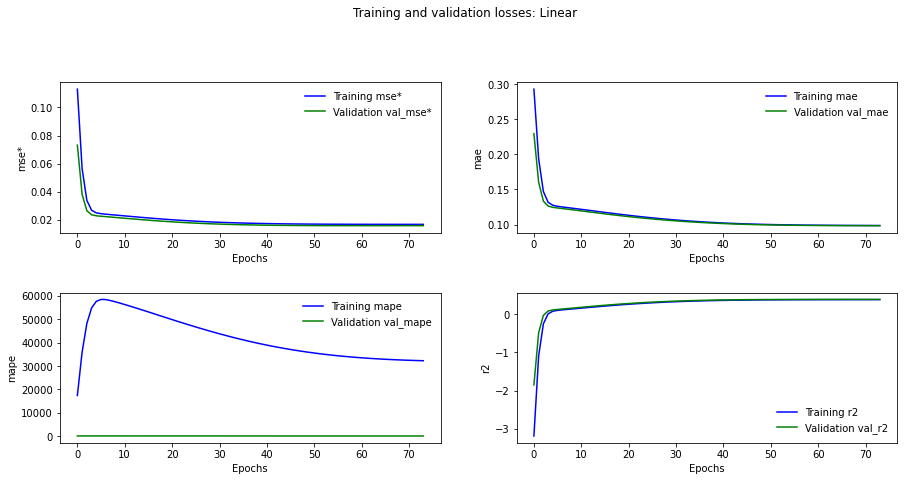

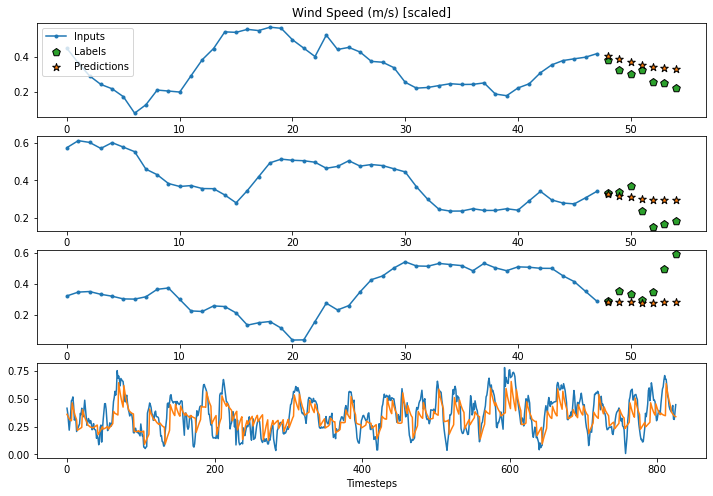

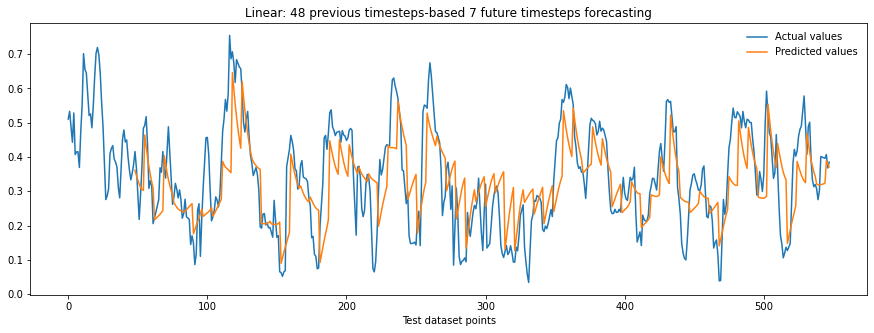

Time taken with the Linear model: 31.73 sec


In [14]:
dp_linear, mw_linear, mc_linear, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=Linear, title="Linear", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## Convolution Neural Network (CNN) model results

In [15]:
class CNN(ModelingClass):
    
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1, conv_width=3):
        super().__init__(mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1)
        self.conv_width = conv_width
        
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, conv_width, features]
            tf.keras.layers.Lambda(lambda x: x[:, -self.conv_width:, :]),
            # Shape => [batch, 1, conv_units]
            tf.keras.layers.Conv1D(filters=256, kernel_size=self.conv_width, activation='relu'),
            # Shape => [batch, 1,  out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 0s 3ms/step - loss: 0.0154 - mae: 0.0937 - mape: 31551.1641 - r2: 0.4305
[0.0154, 0.0937, 31551.1641, 0.4305]

Model evaluation on val dataset:

14/14 [==============================] - 0s 2ms/step - loss: 0.0153 - mae: 0.0957 - mape: 49.2852 - r2: 0.4037
[0.0153, 0.0957, 49.2852, 0.4037]

Model evaluation on test dataset:

7/7 [==============================] - 0s 3ms/step - loss: 0.0155 - mae: 0.0971 - mape: 42.1180 - r2: 0.3836
[0.0155, 0.0971, 42.118, 0.3836]

Modeling metrics on train data set:

rmse: 0.1208 [0.0665, 0.0970, 0.1165, 0.1295, 0.1389, 0.1460, 0.1515]
mse : 0.0154 [0.0044, 0.0094, 0.0136, 0.0168, 0.0193, 0.0213, 0.0229]
mae : 0.0937 [0.0476, 0.0719, 0.0891, 0.1010, 0.1096, 0.1160, 0.1208]
mape: 14184679014400.0000 [5979005517824.0000, 10269699866624.0000, 15018714202112.0000, 14391641636864.0000, 14183493009408.0000, 19340304842752.0000, 20109890420736.0000]
r2  : 0.4305 [0.8362, 0.6518, 0.4

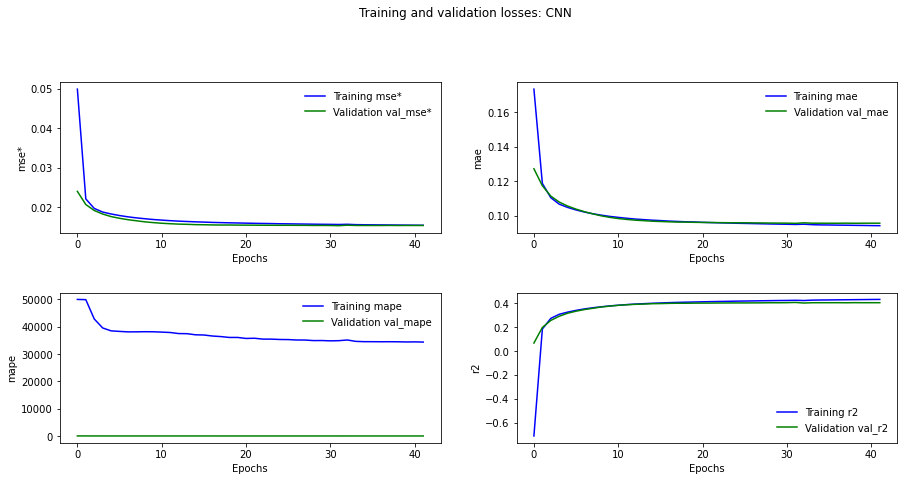

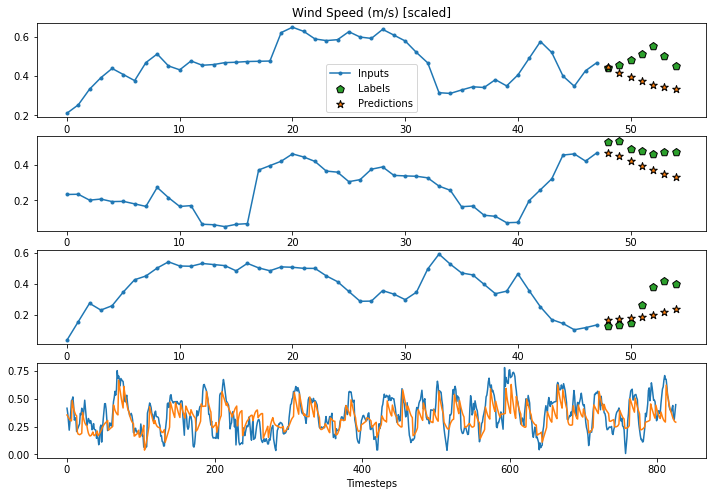

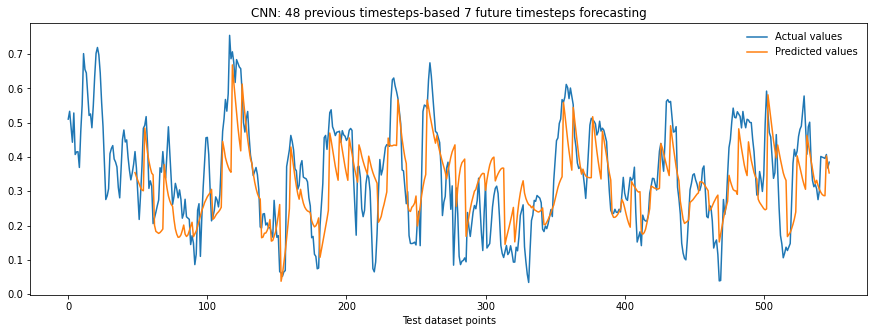

Time taken with the CNN model: 18.21 sec


In [16]:
dp_cnn, mw_cnn, mc_cnn, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=CNN, title="CNN", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## Recurrent Neural Network (RNN/LSTM) model results

In [17]:
class LSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model        
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.LSTM(32, return_sequences=False),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 1s 12ms/step - loss: 0.0135 - mae: 0.0875 - mape: 22683.6875 - r2: 0.5006
[0.0135, 0.0875, 22683.6875, 0.5006]

Model evaluation on val dataset:

14/14 [==============================] - 0s 12ms/step - loss: 0.0130 - mae: 0.0879 - mape: 50.8009 - r2: 0.4957
[0.013, 0.0879, 50.8009, 0.4957]

Model evaluation on test dataset:

7/7 [==============================] - 0s 17ms/step - loss: 0.0122 - mae: 0.0867 - mape: 42.3112 - r2: 0.5161
[0.0122, 0.0867, 42.3112, 0.5161]

Modeling metrics on train data set:

rmse: 0.1135 [0.0640, 0.0939, 0.1116, 0.1224, 0.1296, 0.1346, 0.1386]
mse : 0.0135 [0.0041, 0.0088, 0.0125, 0.0150, 0.0168, 0.0181, 0.0192]
mae : 0.0875 [0.0453, 0.0694, 0.0852, 0.0950, 0.1016, 0.1061, 0.1098]
mape: 10192604364800.0000 [4349502685184.0000, 5990735413248.0000, 10033720983552.0000, 9360219570176.0000, 12061678501888.0000, 14359720886272.0000, 15192655134720.0000]
r2  : 0.5006 [0.8482, 0.6734, 0.

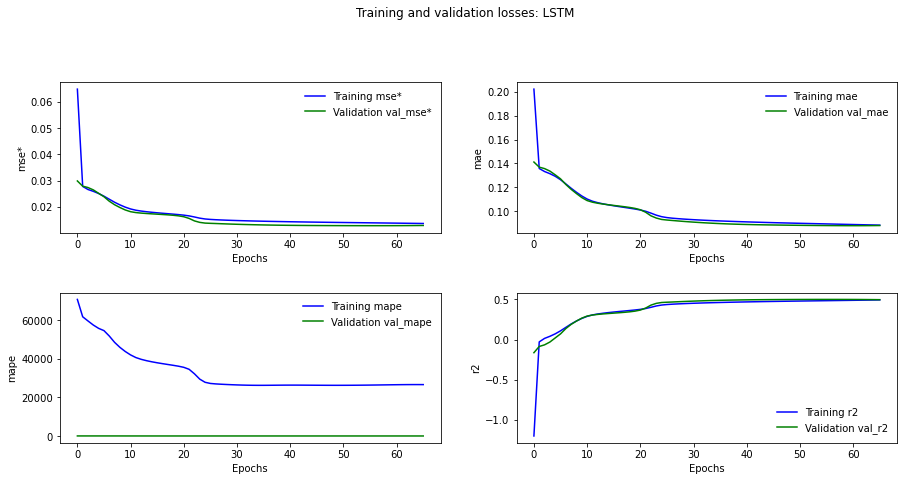

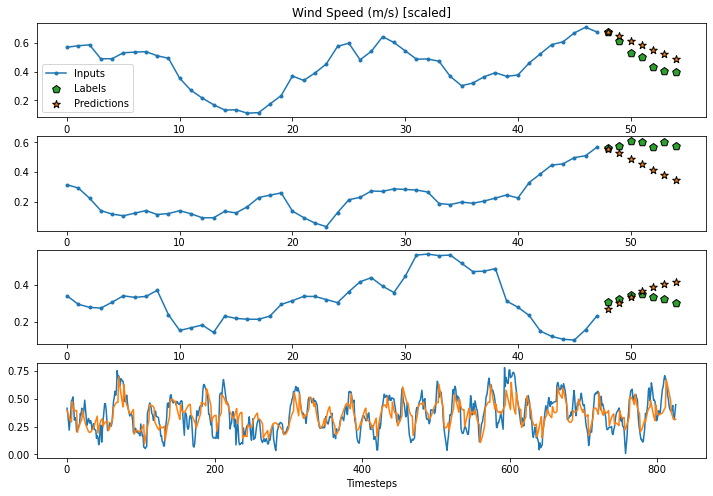

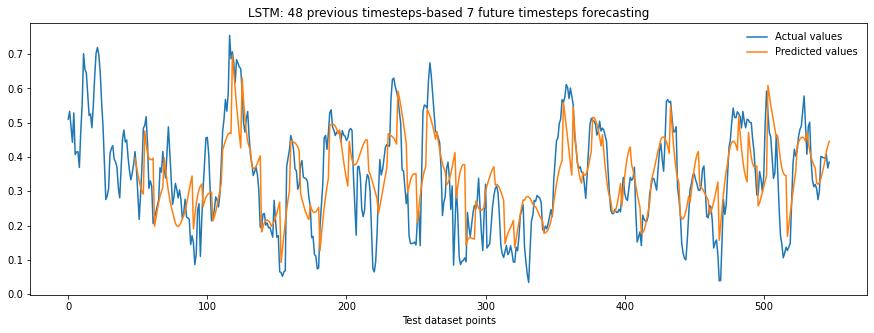

Time taken with the LSTM model: 104.91 sec


In [18]:
dp_lstm, mw_lstm, mc_lstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=LSTM, title="LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## Stacked LSTM model results

In [19]:
class StackedLSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.LSTM(10, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.LSTM(10, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.LSTM(5, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(5),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 1s 16ms/step - loss: 0.0135 - mae: 0.0888 - mape: 25718.4570 - r2: 0.5012
[0.0135, 0.0888, 25718.457, 0.5012]

Model evaluation on val dataset:

14/14 [==============================] - 0s 17ms/step - loss: 0.0143 - mae: 0.0931 - mape: 54.3259 - r2: 0.4448
[0.0143, 0.0931, 54.3259, 0.4448]

Model evaluation on test dataset:

7/7 [==============================] - 0s 16ms/step - loss: 0.0126 - mae: 0.0889 - mape: 42.3943 - r2: 0.5011
[0.0126, 0.0889, 42.3943, 0.5011]

Modeling metrics on train data set:

rmse: 0.1139 [0.0693, 0.0955, 0.1119, 0.1219, 0.1285, 0.1332, 0.1371]
mse : 0.0135 [0.0048, 0.0091, 0.0125, 0.0148, 0.0165, 0.0177, 0.0188]
mae : 0.0888 [0.0519, 0.0725, 0.0864, 0.0951, 0.1010, 0.1052, 0.1090]
mape: 11558563020800.0000 [8523534565376.0000, 9465406423040.0000, 11137583153152.0000, 11476118011904.0000, 12474362363904.0000, 13375689981952.0000, 14457247891456.0000]
r2  : 0.5012 [0.8225, 0.6625, 0

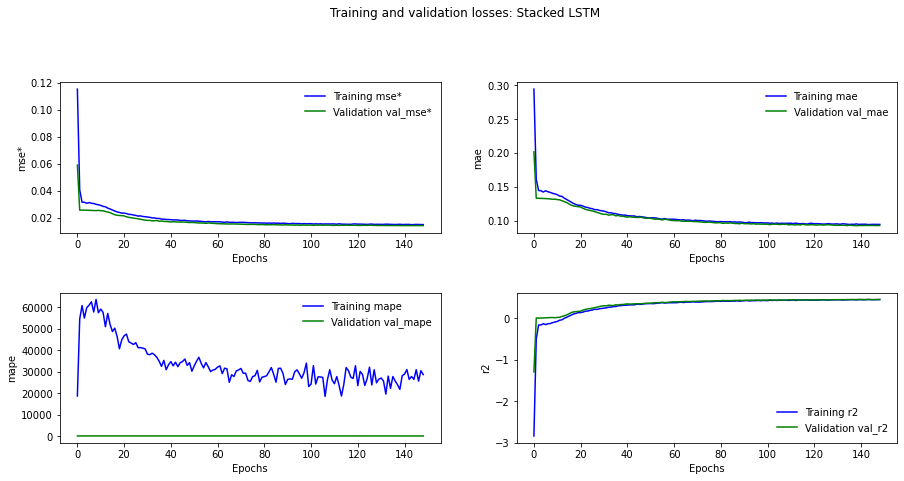

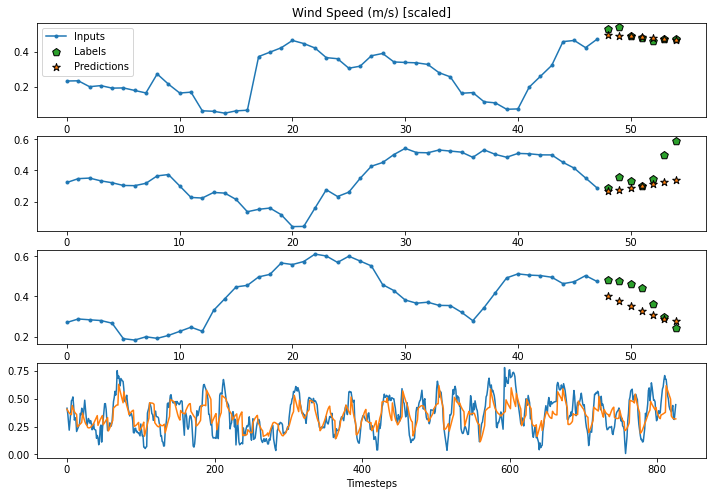

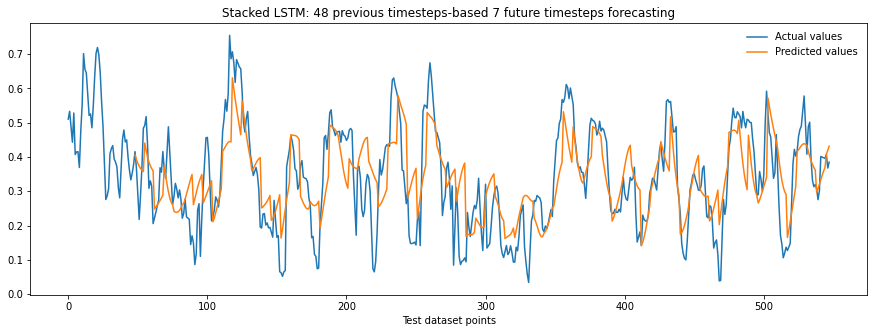

Time taken with the StackedLSTM model: 347.42 sec


In [20]:
dp_slstm, mw_slstm, mc_slstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedLSTM, title="Stacked LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## Stacked GRU model results

In [21]:
class StackedGRU(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `gru_units` just overfits more quickly.
            tf.keras.layers.GRU(10, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.GRU(10, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.GRU(5, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GRU(5),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 1s 9ms/step - loss: 0.0144 - mae: 0.0922 - mape: 27826.2363 - r2: 0.4676
[0.0144, 0.0922, 27826.2363, 0.4676]

Model evaluation on val dataset:

14/14 [==============================] - 0s 9ms/step - loss: 0.0134 - mae: 0.0916 - mape: 49.7836 - r2: 0.4768
[0.0134, 0.0916, 49.7836, 0.4768]

Model evaluation on test dataset:

7/7 [==============================] - 0s 10ms/step - loss: 0.0140 - mae: 0.0951 - mape: 44.0704 - r2: 0.4426
[0.014, 0.0951, 44.0704, 0.4426]

Modeling metrics on train data set:

rmse: 0.1175 [0.0694, 0.0978, 0.1152, 0.1259, 0.1332, 0.1383, 0.1426]
mse : 0.0144 [0.0048, 0.0096, 0.0133, 0.0159, 0.0177, 0.0191, 0.0203]
mae : 0.0922 [0.0516, 0.0746, 0.0896, 0.0991, 0.1056, 0.1102, 0.1144]
mape: 12507167129600.0000 [7741470408704.0000, 8901497978880.0000, 11617578254336.0000, 11587437985792.0000, 13596227534848.0000, 16119016456192.0000, 17986947645440.0000]
r2  : 0.4676 [0.8218, 0.6462, 0.5

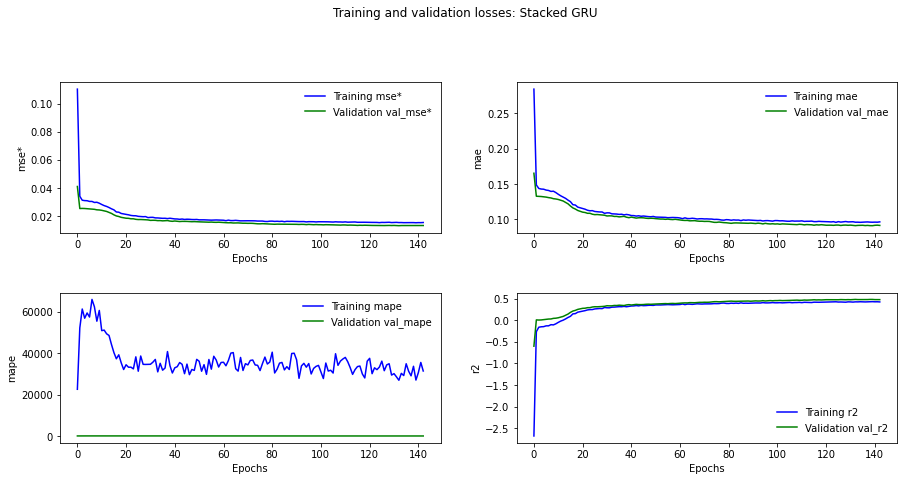

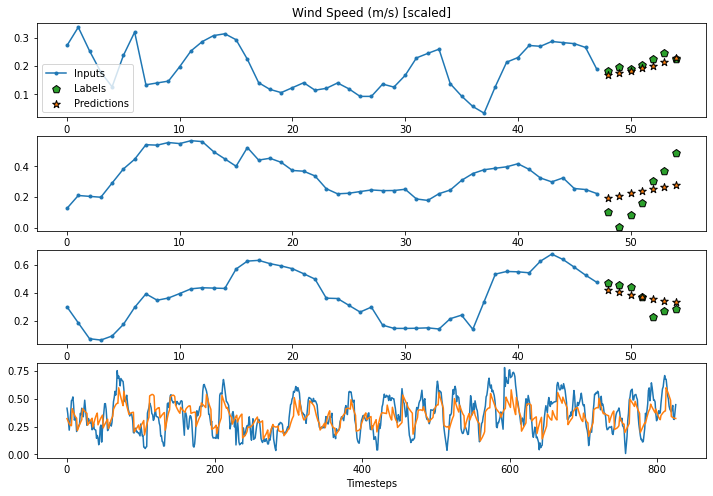

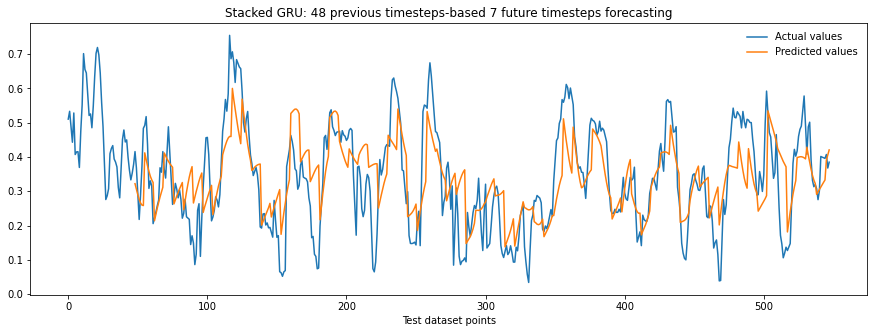

Time taken with the StackedGRU model: 310.13 sec


In [22]:
dp_sgru, mw_sgru, mc_sgru, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedGRU, title="Stacked GRU", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## Stacked Bidirectional LSTM model results

In [23]:
class StackedBiLSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `gru_units` just overfits more quickly.
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
            tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
            #tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, return_sequences=True)),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5)),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 1s 23ms/step - loss: 0.0148 - mae: 0.0937 - mape: 24682.7012 - r2: 0.4542
[0.0148, 0.0937, 24682.7012, 0.4542]

Model evaluation on val dataset:

14/14 [==============================] - 0s 22ms/step - loss: 0.0151 - mae: 0.0976 - mape: 56.8066 - r2: 0.4108
[0.0151, 0.0976, 56.8066, 0.4108]

Model evaluation on test dataset:

7/7 [==============================] - 0s 21ms/step - loss: 0.0140 - mae: 0.0946 - mape: 46.5637 - r2: 0.4430
[0.014, 0.0946, 46.5637, 0.443]

Modeling metrics on train data set:

rmse: 0.1196 [0.0779, 0.1025, 0.1177, 0.1270, 0.1332, 0.1376, 0.1414]
mse : 0.0148 [0.0061, 0.0105, 0.0138, 0.0161, 0.0178, 0.0189, 0.0200]
mae : 0.0937 [0.0587, 0.0784, 0.0914, 0.0996, 0.1053, 0.1094, 0.1130]
mape: 11090685132800.0000 [8287378472960.0000, 9027186589696.0000, 9743732047872.0000, 10643160694784.0000, 11888214671360.0000, 13251016392704.0000, 14794109222912.0000]
r2  : 0.4542 [0.7753, 0.6112, 0.4

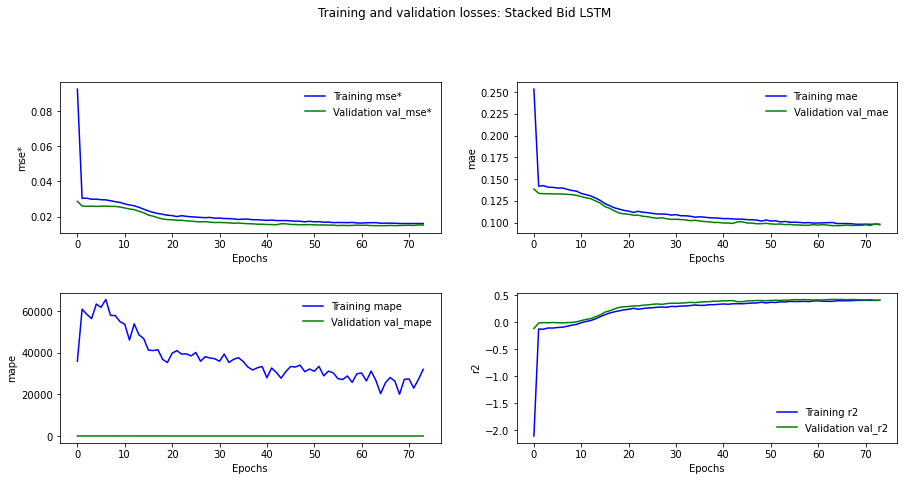

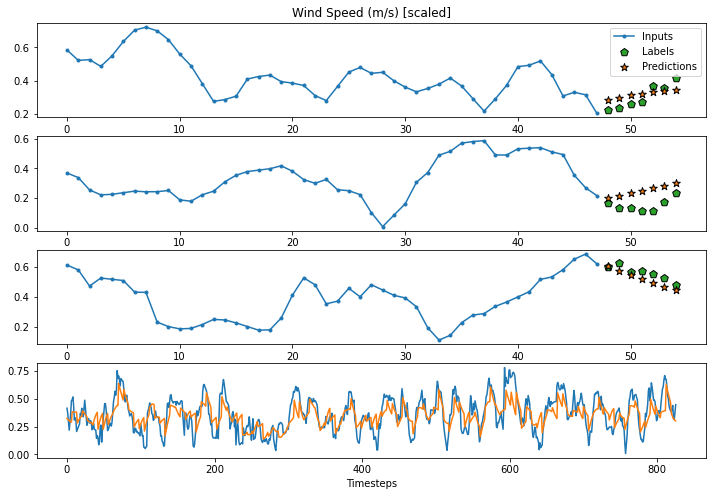

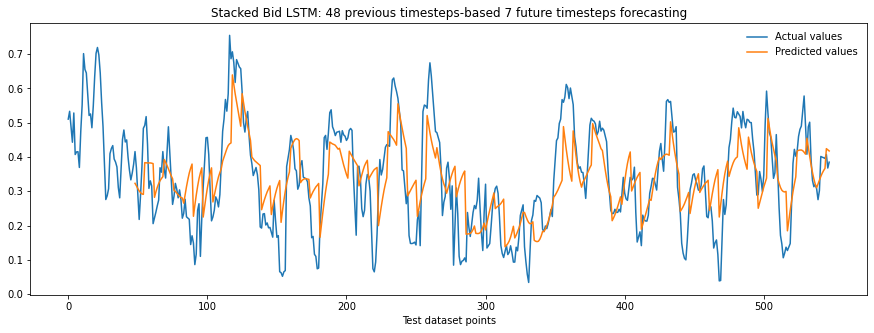

Time taken with the StackedBiLSTM model: 262.51 sec


In [24]:
dp_sblstm, mw_sblstm, mc_sblstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedBiLSTM, title="Stacked Bid LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## Encoder-Decoder LSTM model results

In [25]:
class EnDeLSTM(ModelingClass):
    # build the model 
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(10, return_sequences=False),
            tf.keras.layers.RepeatVector(self.mapdataset.label_width),   
            tf.keras.layers.LSTM(10, activation='relu', return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.label_feature_number, kernel_initializer=tf.initializers.zeros)),
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 1s 13ms/step - loss: 0.0137 - mae: 0.0886 - mape: 23431.5820 - r2: 0.4936
[0.0137, 0.0886, 23431.582, 0.4936]

Model evaluation on val dataset:

14/14 [==============================] - 0s 13ms/step - loss: 0.0137 - mae: 0.0903 - mape: 49.5578 - r2: 0.4671
[0.0137, 0.0903, 49.5578, 0.4671]

Model evaluation on test dataset:

7/7 [==============================] - 0s 13ms/step - loss: 0.0132 - mae: 0.0906 - mape: 41.1300 - r2: 0.4775
[0.0132, 0.0906, 41.13, 0.4775]

Modeling metrics on train data set:

rmse: 0.1144 [0.0657, 0.0952, 0.1124, 0.1232, 0.1302, 0.1351, 0.1392]
mse : 0.0137 [0.0043, 0.0091, 0.0126, 0.0152, 0.0170, 0.0182, 0.0194]
mae : 0.0886 [0.0474, 0.0710, 0.0858, 0.0959, 0.1025, 0.1068, 0.1105]
mape: 10529561804800.0000 [8101131976704.0000, 8484811702272.0000, 10786546122752.0000, 10238971346944.0000, 11050736943104.0000, 12457303080960.0000, 12587425071104.0000]
r2  : 0.4936 [0.8402, 0.6648, 0.5

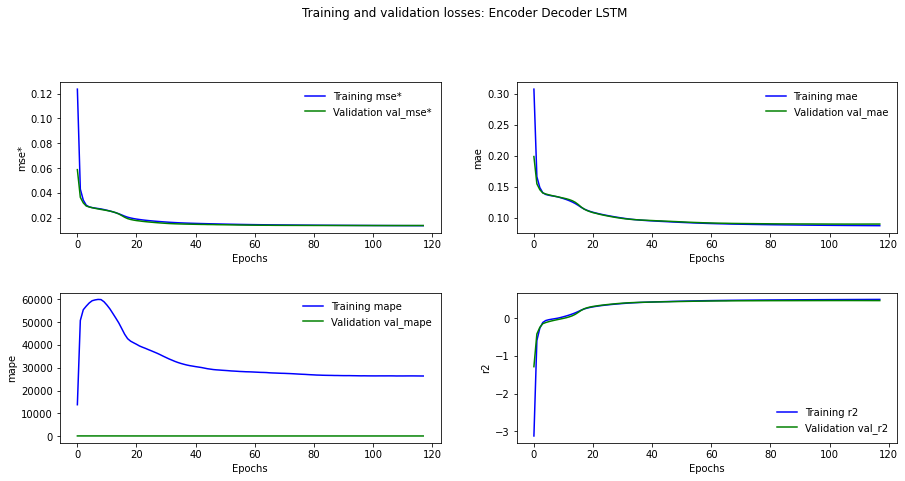

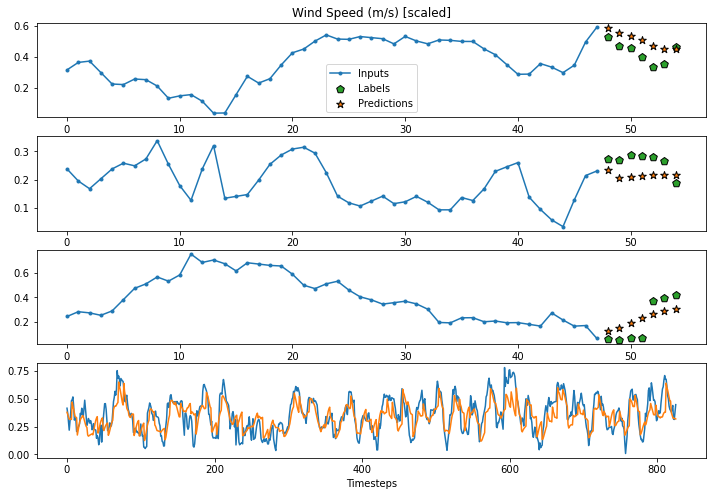

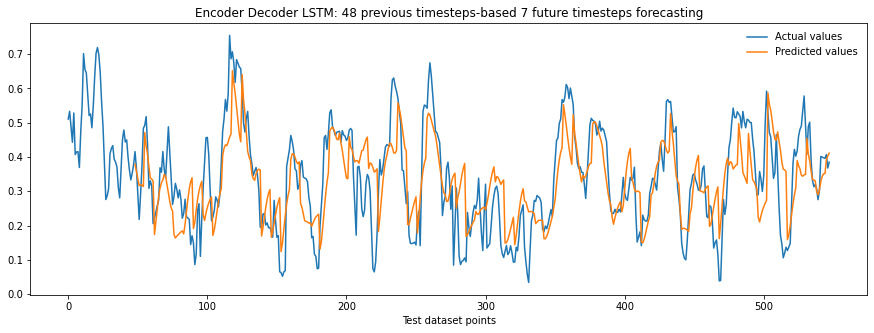

Time taken with the EnDeLSTM model: 202.04 sec


In [26]:
dp_edlstm, mw_edlstm, mc_edlstm , train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=EnDeLSTM, title="Encoder Decoder LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## CNN-LSTM Encoder-Decoder model results

In [28]:
class CNNLSTMEnDe(ModelingClass):
    
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1, filters=64, conv_width=3):
        super().__init__(mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1)
        self.filters = filters
        self.conv_width = conv_width
        
    # build the model 
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([            
            tf.keras.layers.Conv1D(filters=self.filters, kernel_size=self.conv_width, activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.RepeatVector(self.mapdataset.label_width),
            tf.keras.layers.LSTM(10, activation='relu', return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.label_feature_number, kernel_initializer=tf.initializers.zeros)),
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 1s 19ms/step - loss: 0.0138 - mae: 0.0911 - mape: 27081.4355 - r2: 0.4908
[0.0138, 0.0911, 27081.4355, 0.4908]

Model evaluation on val dataset:

14/14 [==============================] - 0s 17ms/step - loss: 0.0157 - mae: 0.1002 - mape: 55.8295 - r2: 0.3878
[0.0157, 0.1002, 55.8295, 0.3878]

Model evaluation on test dataset:

7/7 [==============================] - 0s 20ms/step - loss: 0.0157 - mae: 0.1007 - mape: 45.0239 - r2: 0.3776
[0.0157, 0.1007, 45.0239, 0.3776]

Modeling metrics on train data set:

rmse: 0.1164 [0.0906, 0.1030, 0.1118, 0.1194, 0.1254, 0.1302, 0.1344]
mse : 0.0138 [0.0082, 0.0106, 0.0125, 0.0143, 0.0157, 0.0170, 0.0181]
mae : 0.0911 [0.0686, 0.0789, 0.0865, 0.0938, 0.0992, 0.1037, 0.1073]
mape: 12171540889600.0000 [9472316538880.0000, 9479205683200.0000, 10631016087552.0000, 11181730299904.0000, 12243141918720.0000, 15504434528256.0000, 16688937435136.0000]
r2  : 0.4908 [0.6959, 0.6074, 

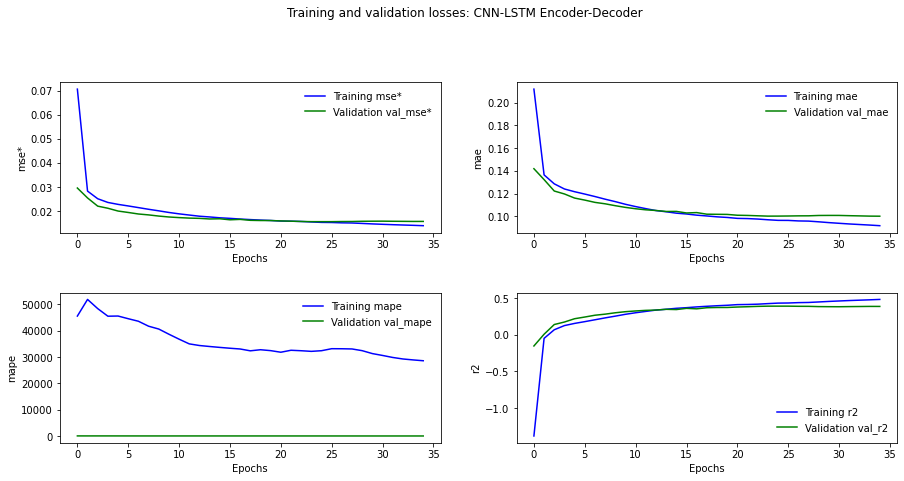

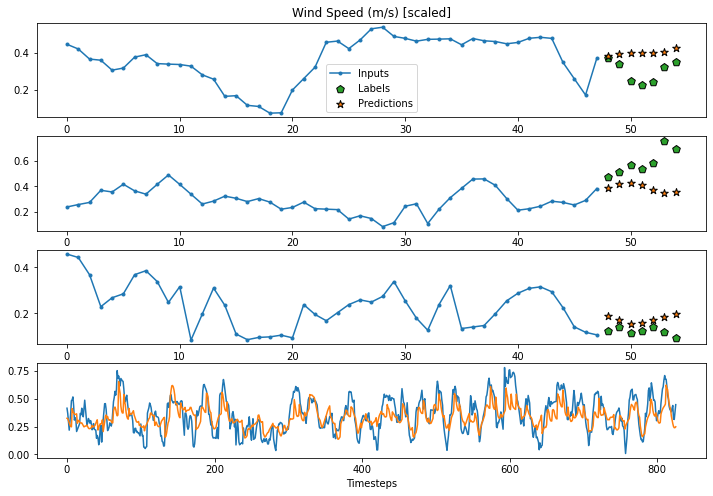

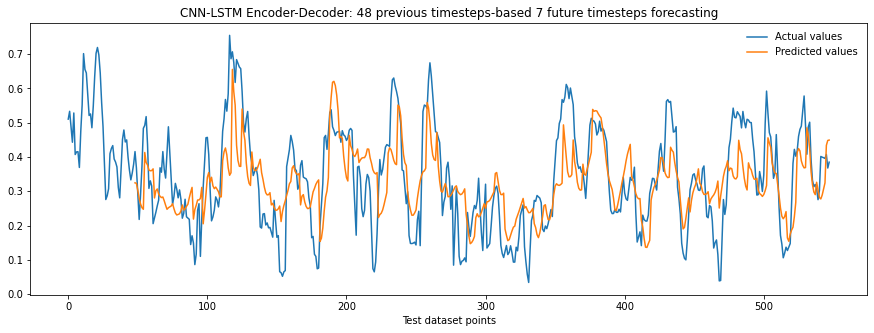

Time taken with the CNNLSTMEnDe model: 85.18 sec


In [29]:
dp_cnnlstmed, mw_cnnlstmed, mc_cnnlstmed , train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=CNNLSTMEnDe, title="CNN-LSTM Encoder-Decoder", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## ConvLSTM Encoder-Decoder model results

In [30]:
class ConvLSTMEnDe(ModelingClass):
    
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1, filters=64):
        super().__init__(mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1)
        
        self.filters = filters
        
        self.train_x = np.concatenate(list(map(lambda x: x[0].numpy(), mapdataset.train)))
        #self.train_x = np.vstack(np.array(list(map(lambda x: x[0].numpy(), mapdataset.train)), dtype=object))
        self.train_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdataset.train)))
        self.val_x = np.concatenate(list(map(lambda x: x[0].numpy(), mapdataset.val)))
        self.val_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdataset.val)))
        self.test_x = np.concatenate(list(map(lambda x: x[0].numpy(), mapdataset.test)))
        self.test_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdataset.test)))
    
    def getFactors(self, n):
        factors = []
        for i in range(1, n + 1):
            if n % i == 0:
                factors.append(i)
        if len(factors) == 2:
            return (factors[0], n)
        else:
            return (factors[1], int(n / factors[1]))
    @property
    def reshapeparams(self):
        return self.getFactors(self.mapdataset.input_width)
    
    def reshape(self, data):
        data = data.reshape(data.shape[0], self.reshapeparams[0], 1, self.reshapeparams[1], data.shape[2])
        return data
        
    @property
    def trainreshape(self):
        return self.reshape(self.train_x)
    @property
    def valreshape(self):
        return self.reshape(self.val_x)
    @property
    def testreshape(self):
        return self.reshape(self.test_x)
        
    # build the model 
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(self.trainreshape.shape[1], self.trainreshape.shape[2], self.trainreshape.shape[3], self.trainreshape.shape[4])), 
            tf.keras.layers.ConvLSTM2D(filters=self.filters, kernel_size=(1, self.mapdataset.label_width), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.RepeatVector(self.train_y.shape[1]),
            tf.keras.layers.LSTM(10, activation='relu', return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.label_feature_number)),
            ])
        return model

    # train the model
    def train(self):
        # Building the model
        self.model = self.modelbuild()
        # Initiating the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Instantiate an optimizer before passing it to model.compile() or pass it by its string identifier.
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        # fit network
        if (self.val_x is not None) & (self.val_y is not None):
            self.history = self.model.fit(
                self.trainreshape,
                self.train_y,
                validation_data=(self.valreshape, self.val_y),
                epochs=self.epochs, 
                batch_size=self.mapdataset.batch_size, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        else:           
            self.history = self.model.fit(
                self.trainreshape,
                self.train_y,
                epochs=self.epochs, 
                batch_size=self.mapdataset.batch_size, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        return self.history
    
    def modelevaluate(self, train_performance, val_performance, test_performance):
        for x in ["train", "val", "test"]:
            print("\nModel evaluation on %s dataset:\n"%x)
            eval("%s_performance"%x)[self.__class__.__name__] = self.model.evaluate(eval("self.%sreshape"%x), eval("self.%s_y"%x), batch_size=self.mapdataset.batch_size)  
            print(list(map(lambda x: round(x, 4), eval("%s_performance"%x)[self.__class__.__name__])))
        return train_performance, val_performance, test_performance

    def computemetrics(self, reshape_real_x, real_y): 
        real_y = real_y.reshape(real_y.shape[0], real_y.shape[1])
        pred_y = self.model.predict(reshape_real_x)
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[1])

        RMSE = mean_squared_error(real_y, pred_y, squared=False)
        MSE = mean_squared_error(real_y, pred_y)
        MAE = mean_absolute_error(real_y, pred_y)
        MAPE = 100*mean_absolute_percentage_error(real_y, pred_y)
        R2 = r2_score(real_y, pred_y)   
        # calculate the metric score for each timestep
        rmse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values', squared=False)
        mse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values')
        mae_scores = mean_absolute_error(real_y, pred_y, multioutput='raw_values')
        mape_scores = 100*mean_absolute_percentage_error(real_y, pred_y, multioutput='raw_values')
        r2_scores = r2_score(real_y, pred_y, multioutput='raw_values')
        print('rmse: %.4f [%s]' %(RMSE, ', '.join(['%.4f' % s for s in rmse_scores])))
        print('mse : %.4f [%s]' %(MSE, ', '.join(['%.4f' % s for s in mse_scores])))
        print('mae : %.4f [%s]' %(MAE, ', '.join(['%.4f' % s for s in mae_scores])))
        print('mape: %.4f [%s]' %(MAPE, ', '.join(['%.4f' % s for s in mape_scores])))
        print('r2  : %.4f [%s]' %(R2, ', '.join(['%.4f' % s for s in r2_scores]))) 
    
    @property
    def trainmetrics(self):
        return self.computemetrics(self.trainreshape, self.train_y)
    @property
    def valmetrics(self):
        return self.computemetrics(self.valreshape, self.val_y)
    @property
    def testmetrics(self):
        return self.computemetrics(self.testreshape, self.test_y)

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['Wind Speed (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None


Model evaluation on train dataset:

48/48 [==============================] - 1s 27ms/step - loss: 0.0135 - mae: 0.0890 - mape: 26077.1895 - r2: 0.5017
[0.0135, 0.089, 26077.1895, 0.5017]

Model evaluation on val dataset:

14/14 [==============================] - 0s 26ms/step - loss: 0.0162 - mae: 0.1009 - mape: 51.9174 - r2: 0.3703
[0.0162, 0.1009, 51.9174, 0.3703]

Model evaluation on test dataset:

7/7 [==============================] - 0s 25ms/step - loss: 0.0151 - mae: 0.0991 - mape: 43.0255 - r2: 0.4003
[0.0151, 0.0991, 43.0255, 0.4003]

Modeling metrics on train data set:

rmse: 0.1145 [0.0803, 0.0959, 0.1095, 0.1190, 0.1262, 0.1322, 0.1381]
mse : 0.0135 [0.0064, 0.0092, 0.0120, 0.0142, 0.0159, 0.0175, 0.0191]
mae : 0.0890 [0.0615, 0.0725, 0.0842, 0.0926, 0.0990, 0.1041, 0.1089]
mape: 11721428172800.0000 [11699304267776.0000, 11003999813632.0000, 10986766467072.0000, 11330015723520.0000, 12180794638336.0000, 12389051269120.0000, 12460066078720.0000]
r2  : 0.5017 [0.7614, 0.6599,

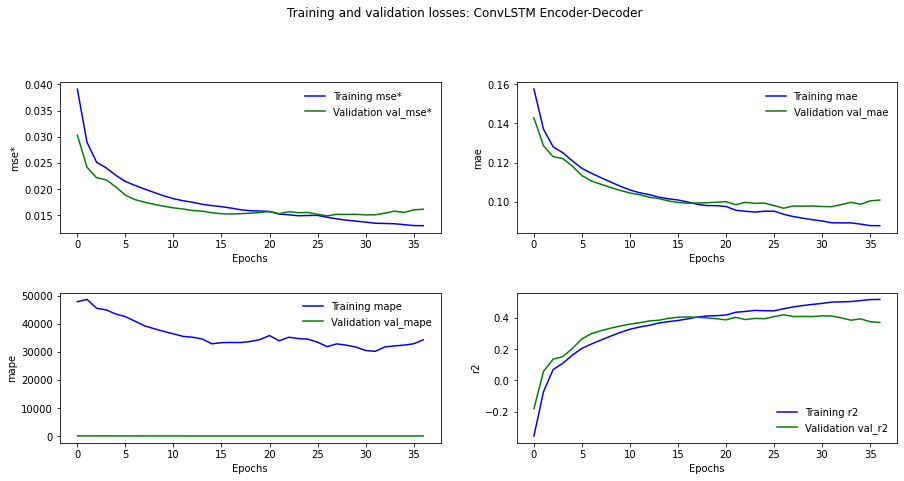

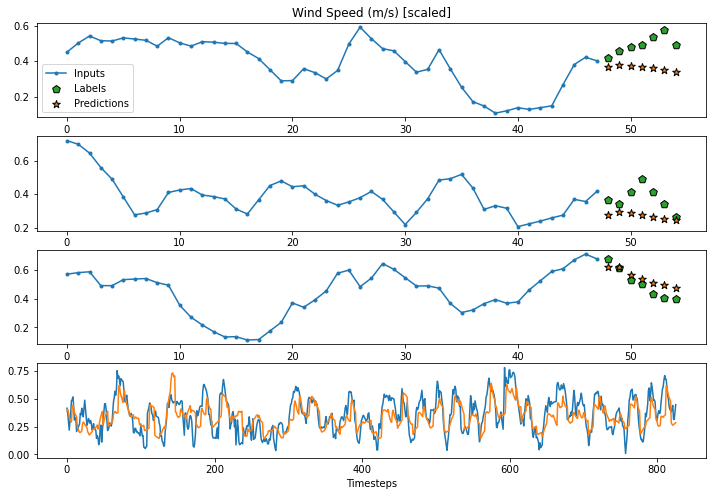

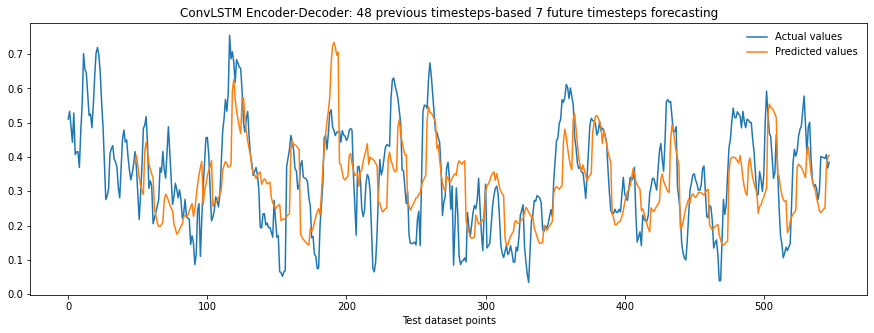

Time taken with the ConvLSTMEnDe model: 188.70 sec


In [31]:
dp_convlstmed, mw_convlstmed, mc_convlstmed , train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=ConvLSTMEnDe, title="ConvLSTM Encoder-Decoder", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

## Performance results

In [33]:
def perfplot(train_performance, val_performance, test_performance, metric_name, anymodel, ylabel):
    # set width of bar
    barWidth = 0.25
    # set height of bar      
    metric_index = anymodel.metrics_names.index(metric_name)
    train_metric = [v[metric_index] for v in train_performance.values()]
    val_metric = [v[metric_index] for v in val_performance.values()]
    test_metric = [v[metric_index] for v in test_performance.values()]
    # Set position of bar on X axis
    r1 = np.arange(len(test_performance))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    # Make the plot
    plt.figure(figsize=(14, 8))
    plt.bar(r1, train_metric, width=barWidth, label='Train')
    plt.bar(r2, val_metric, width=barWidth, label='Validation')
    plt.bar(r3, test_metric, width=barWidth, label='Test')        
    # Set axis label
    plt.ylabel(ylabel)
    # Add xticks on the middle of the group bars
    plt.xticks([r + barWidth for r in range(len(test_performance))], 
               labels=test_performance.keys(), rotation=45)
    plt.legend()
    plt.show()
    
    print(pd.DataFrame(np.array([train_metric, val_metric, test_metric]),
                 columns=test_performance.keys(), 
                 index=["Train", "Val", "Test"]).round(4).transpose())

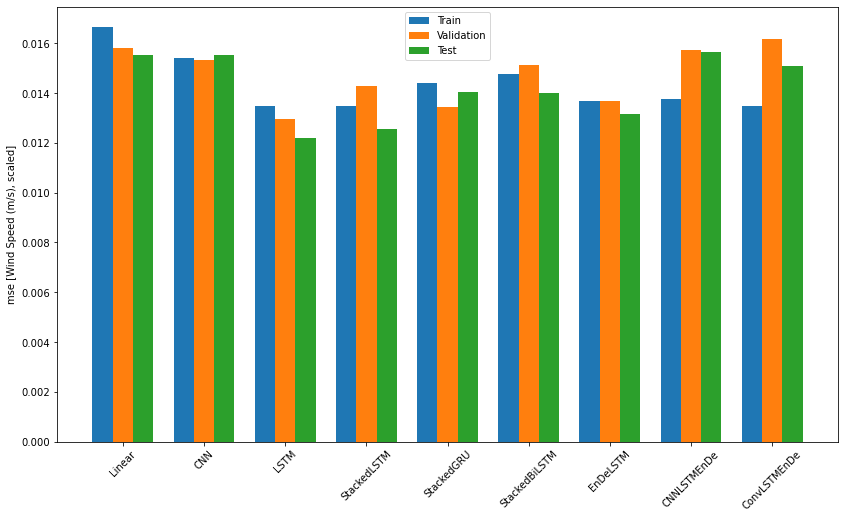

                Train     Val    Test
Linear         0.0166  0.0158  0.0155
CNN            0.0154  0.0153  0.0155
LSTM           0.0135  0.0130  0.0122
StackedLSTM    0.0135  0.0143  0.0126
StackedGRU     0.0144  0.0134  0.0140
StackedBiLSTM  0.0148  0.0151  0.0140
EnDeLSTM       0.0137  0.0137  0.0132
CNNLSTMEnDe    0.0138  0.0157  0.0157
ConvLSTMEnDe   0.0135  0.0162  0.0151


In [34]:
perfplot(train_performance, val_performance, test_performance, metric_name='loss', anymodel=mc_slstm.model, ylabel='mse [Wind Speed (m/s), scaled]')

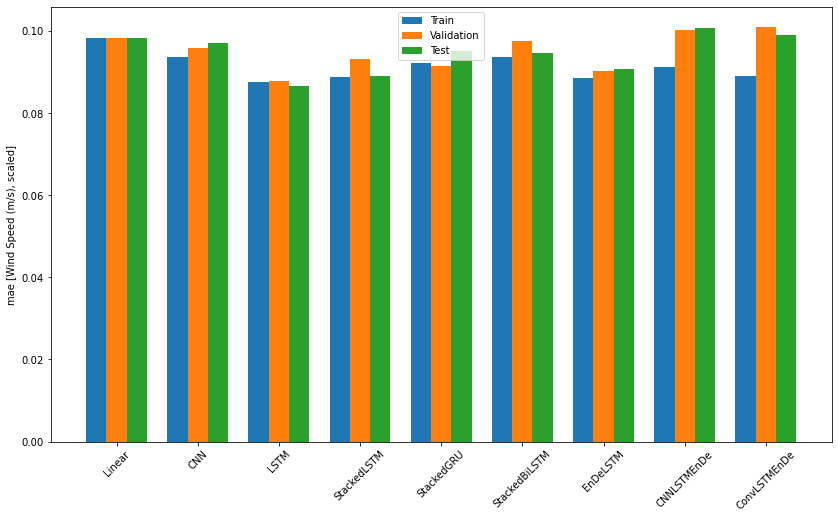

                Train     Val    Test
Linear         0.0983  0.0983  0.0983
CNN            0.0937  0.0957  0.0971
LSTM           0.0875  0.0879  0.0867
StackedLSTM    0.0888  0.0931  0.0889
StackedGRU     0.0922  0.0916  0.0951
StackedBiLSTM  0.0937  0.0976  0.0946
EnDeLSTM       0.0886  0.0903  0.0906
CNNLSTMEnDe    0.0911  0.1002  0.1007
ConvLSTMEnDe   0.0890  0.1009  0.0991


In [35]:
perfplot(train_performance, val_performance, test_performance, metric_name='mae', anymodel=mc_slstm.model, ylabel='mae [Wind Speed (m/s), scaled]')

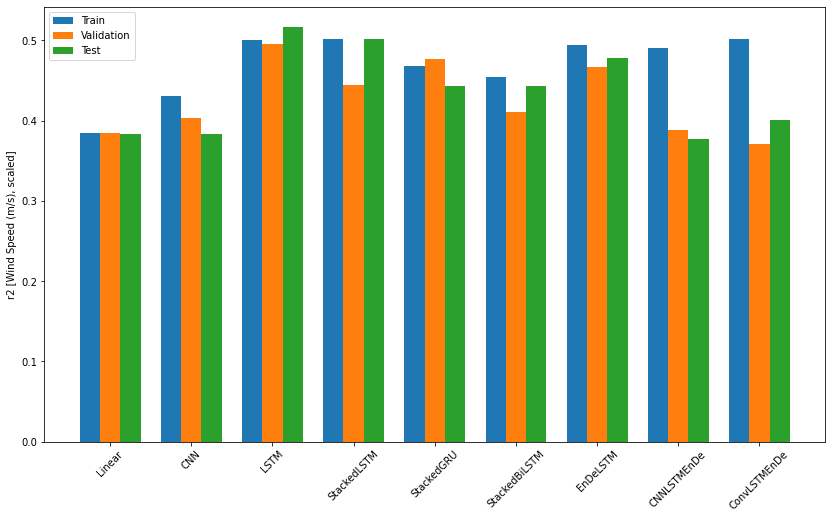

                Train     Val    Test
Linear         0.3843  0.3847  0.3832
CNN            0.4305  0.4037  0.3836
LSTM           0.5006  0.4957  0.5161
StackedLSTM    0.5012  0.4448  0.5011
StackedGRU     0.4676  0.4768  0.4426
StackedBiLSTM  0.4542  0.4108  0.4430
EnDeLSTM       0.4936  0.4671  0.4775
CNNLSTMEnDe    0.4908  0.3878  0.3776
ConvLSTMEnDe   0.5017  0.3703  0.4003


In [36]:
perfplot(train_performance, val_performance, test_performance, metric_name='r2', anymodel=mc_slstm.model, ylabel='r2 [Wind Speed (m/s), scaled]')

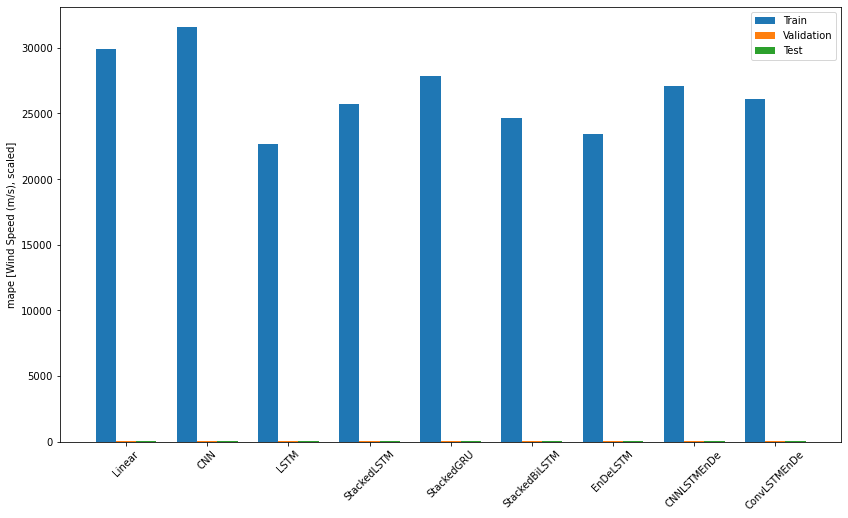

                    Train      Val     Test
Linear         29874.0469  54.7183  43.5357
CNN            31551.1641  49.2852  42.1180
LSTM           22683.6875  50.8009  42.3112
StackedLSTM    25718.4570  54.3259  42.3943
StackedGRU     27826.2363  49.7836  44.0704
StackedBiLSTM  24682.7012  56.8066  46.5637
EnDeLSTM       23431.5820  49.5578  41.1300
CNNLSTMEnDe    27081.4355  55.8295  45.0239
ConvLSTMEnDe   26077.1895  51.9174  43.0255


In [37]:
perfplot(train_performance, val_performance, test_performance, metric_name='mape', anymodel=mc_slstm.model, ylabel='mape [Wind Speed (m/s), scaled]')

References: 
1. https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output
2. https://github.com/mnassrib/time-series-forecasting-models-for-wind-speed